In [1]:
%matplotlib inline


# Station Plot

Make a station plot, complete with sky cover and weather symbols.

Notebook adapted from: https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import reduce_point_density
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot

## The setup

First read in the data. We use the metar reader because it simplifies a lot of tasks,
like dealing with separating text and assembling a pandas dataframe
https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html

We are building an archive of these files (goes back to mid-May 2021), which I'll point you to if you want to access different dates/times. (Or there are other sources for older files with surface data.)



In [3]:
## define the time we're plotting
datetime = pd.Timestamp(2023, 1, 3, 18)  ## year, month, day, hour, (minute, second)

In [8]:
#data = metar.parse_metar_file('metar_20211211_0300.txt')
data = metar.parse_metar_file("metar_"+datetime.strftime("%Y%m%d_%H%M")+".txt")

# Drop rows with missing winds or temperature
data = data.dropna(how='any', subset=['wind_direction', 'wind_speed', 'air_temperature'])

Now we have the METAR data in a much nicer format (a pandas dataframe):

In [9]:
data

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KMMU,KMMU,40.78,-74.42,57.0,2023-01-03 17:45:00,0.0,0.0,NaN,3218.688,RA,...,10.0,10.0,29.96,63,10,0,,1014.98,-0.000000e+00,-0.000000
KFFA,KFFA,36.02,-75.67,4.0,2023-01-03 17:55:00,210.0,3.0,NaN,16093.440,NaN,...,19.0,13.0,30.11,0,0,0,AO2 T01920129 10342 21076,1019.94,1.500000e+00,2.598076
KHNZ,KHNZ,36.36,-78.53,161.0,2023-01-03 17:55:00,220.0,12.0,18.0,16093.440,NaN,...,19.0,9.0,30.06,0,0,0,AO2 T01910087 10195 20112,1017.96,7.713451e+00,9.192533
KCLK,KCLK,35.53,-98.93,492.0,2023-01-03 17:55:00,300.0,8.0,16.0,16093.440,NaN,...,8.0,-2.0,29.85,0,0,0,AO2,1012.24,6.928203e+00,-4.000000
KGWW,KGWW,35.47,-77.97,41.0,2023-01-03 17:55:00,220.0,12.0,16.0,16093.440,NaN,...,23.0,15.0,30.10,0,0,0,AO2 T02260145 10226 20114,1019.47,7.713451e+00,9.192533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FNLU,FNLU,-8.83,13.22,70.0,2023-01-03 18:00:00,230.0,11.0,NaN,9999.000,NaN,...,28.0,23.0,29.77,0,0,0,NOSIG,1007.92,8.426489e+00,7.070664
FNCA,FNCA,-5.53,12.17,20.0,2023-01-03 18:00:00,180.0,5.0,NaN,9000.000,NaN,...,24.0,23.0,29.80,0,0,0,,1009.22,-6.123234e-16,5.000000
CZUM,CZUM,53.53,-64.08,440.0,2023-01-03 18:16:00,200.0,4.0,NaN,9656.064,-SN,...,-9.0,-11.0,29.57,71,0,0,SLP049,1006.02,1.368081e+00,3.758770


This sample data has *way* too many stations to plot all of them. The number
of stations plotted will be reduced using `reduce_point_density`.



In [10]:
# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 150km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)
data = data[reduce_point_density(point_locs, 200000.)]

## The payoff



/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/rschumac/mambaforge/envs/ats641_2023/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


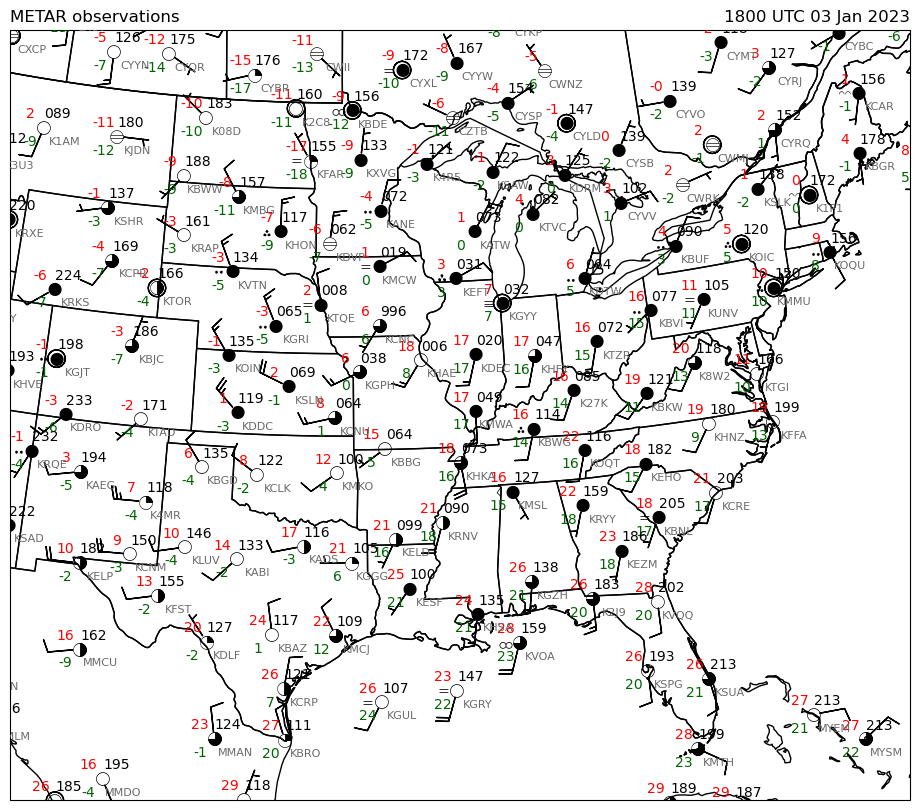

In [11]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Set plot bounds
#ax.set_extent((-118, -73, 23, 50))
ax.set_extent((-108,-73, 23, 50))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', data['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values,
                     length=6)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((1.5, -1), data['station_id'].values, fontsize=8, color='dimgray')

plt.title('METAR observations', loc='left')
plt.title(datetime.strftime("%H%M UTC %d %b %Y"), loc='right')

plt.show()

In [ ]:
### if you want to save your file, use code like this (you can use a better filename if you like)
fig.savefig("sfc_test.png", bbox_inches='tight', facecolor='white', transparent=False)